# Tutorial
First, we need to import all the necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

# repository modules
import models
import train
import adversarial.carlini_wagner as cw
import mesh.laplacian
import dataset
import utils

The training and test data is loaded in memory using the `dataset` local module. Before using the FAUST dataset download it from [here](http://faust.is.tue.mpg.de/) and place it in `{repository-root}/datasets/faust/raw/`.

In [2]:
REPO_ROOT = os.path.join(os.path.dirname(os.path.realpath('__file__')),"..")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/data.pt")

traindata = dataset.FaustDataset(FAUST, train=True, test=False, transform_data=True)
testdata = dataset.FaustDataset(FAUST, train=False, test=True,  transform_data=True)

Then we can define the classifier for the human pose classefication task; download the classifier parameters from [here](https://drive.google.com/open?id=1IllCPPPcqFL3v8BDxCyswzEpxoGyXvMe). Move these parameters in `{repository-root}/model_data/data.pt` .

In [3]:
model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=PARAMS_FILE)

Training and evaluation can be done through the `train` local module.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


tensor(0.7500)


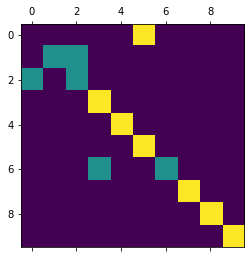

In [4]:
#train network
train.train(
    train_data=traindata,
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=0)

#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=testdata, classifier=model)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

### Carlini & Wagner Method
It is possible to create adversarial examples through the **AdversarialExampleBuilder** and **AdversarialExample** classes  

In [40]:
# get a random mesh from the dataset and a random target class
import random
i = random.randint(0, len(traindata))
x = traindata[i].pos
e = traindata[i].edge_index.t() # needs to be transposed
f = traindata[i].face.t() # needs to be transposed
y = traindata[i].y
t = random.randint(0, traindata.num_classes)
eigs_num = 10

# configure adversarial example components
builder = cw.AdversarialExampleBuilder()
builder.set_classifier(model)
builder.set_perturbation_type("spectral", eigs_num=eigs_num)
builder.set_mesh(x, e, f)
builder.set_target(t)
builder.set_distortion_function(cw.L2_distortion)
builder.set_adversarial_coeff(0.0001)
adex = builder.build(100, 8e-4, usetqdm="standard")
print("adversarial attack: "+("successful" if adex.is_successful else "unsuccessful"))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


adversarial attack: unsuccessful


We can finally see the actual adversarial example using **Plotly** (note: you need to install plotly before-hand)

In [5]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()

visualize(adex.perturbed_pos, f, (adex.perturbed_pos-x).norm(p=2,dim=-1))

NameError: name 'adex' is not defined

### Fast Gradient Sign Method

In [6]:
import random

import adversarial.iterative_gradient as ig
from mesh.laplacian import LB_v2
import utils

i = random.randint(0, len(traindata)-1)
x = traindata[i].pos
e = traindata[i].edge_index.t() # needs to be transposed
f = traindata[i].face.t() # needs to be transposed
y = traindata[i].y
t = torch.tensor([random.randint(0, traindata.num_classes-1)], dtype=torch.int64, device=x.device)
print(t,y)
N=20

if model(x).argmax() == y:

    eigvals,eigvecs = utils.eigenpairs(x, f, K=100)
    _,(_,a) = LB_v2(x,f)
    x_adv = ig.fast_gradient(classifier=model, x=x, y=y, eigvecs=eigvecs, areavec=a)

    print(model(x_adv).argmax().item())
    print(model(x).argmax().item())
    visualize(x_adv,f,(x-x_adv).norm(p=2,dim=-1))

    '''
    n = x.shape[0]
    tmpx = torch.cat([x, x_adv],dim=0)
    tmpf = torch.cat([f, f+n], dim=0)
    color = torch.zeros([n*2],dtype=x.dtype, device=x.device)
    color[n:] = (x-x_adv).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)'''
else:
    print("Oh no!")

tensor([2]) tensor([7])
4
7


In [14]:
r = x-x_adv
counter = 0
for _ in tqdm.trange(N):
    it = i# random.randint(0, len(traindata)-1)
    xt = traindata[it].pos
    y = traindata[it].y
    
    yp = model(xt+r).argmax().item()
    yc = model(xt).argmax().item()

    if yp != y and yc!=yp: counter +=1
print(counter/N)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]

0.0


In [ ]:
import adversarial.uap as uap
uap.UAP_computation(testdata,model,delta=0.5,eps=0,K=30)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.05555555555555555


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.1111111111111111


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.3333333333333333


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.2777777777777778


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.2777777777777778


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.2777777777777778


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

mean error: 0.2222222222222222


 56%|█████████████████████████████████████████████▌                                    | 10/18 [01:12<00:47,  5.94s/it]